In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import fklab.signals.multitaper as mt
import scipy.signal
import fklab.signals.filter

%matplotlib notebook

plt.style.use('seaborn-ticks')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import itertools

from fklab.io.data import import_position
from fklab.io.data import import_environment
import fklab.geometry.utilities
import fklab.segments as segments
from fklab.segments import Segment

from fklab.signals.smooth import kernelsmoothing
from fklab.behavior import task_analysis

from data_analysis import loading

loading.load_project('/media/kasia/K/Neuropixeldata/Th1_ca3_9/catgt_29112019_g0/')
loading.load_lfp('29112019_g0_t0.imec0.lf.bin')

In [5]:
loading.load_cluster()
ls_data = loading.cluster_data[loading.cluster_data['depth'] > 3000]
loading.load_position('/media/kasia/K/Neuropixeldata/Th1_ca3_9/2019-11-29_13-20-45/epochs/training/position.hdf5')
loading.load_position_yaml()
loading.load_environment_yaml()
loading.load_kilosort()
loading.load_event('/media/kasia/K/Neuropixeldata/Th1_ca3_9/2019-11-29_13-20-45/Events.nev',)

OSError: Unable to open file (file signature not found)

In [3]:
from data_analysis import time_synchro

time_shift = time_synchro.synchro(
    '/media/kasia/K/Neuropixeldata/Th1_ca3_9/2019-11-29_13-20-45/Events.nev', 
    loading.lfp_data_path,
)

time_shift

mean -6.2704902586705185
std 0.004703390860767995


-6.2704902586705185

In [4]:
position_time = np.array(loading.position_time)
corrected_time = position_time + time_shift
corrected_time


array([12103.76882074, 12103.80838074, 12103.84896074, ...,
       14473.63280074, 14473.67309774, 14473.71245774])

In [5]:
#here we access the keys of the dictionary position_yaml
epoch = loading.position_yaml['source']['epoch']
epoch
open_box_epoch = [12033, 13828]
linear_track_epoch = [13883, 14456]

sleep_box_epoch = [14502, 15686]


In [6]:
from fklab.geometry.shapes import rectangle
open_box_data = loading.environment_yaml['open_box']['shapes']['open_box']['shape']
open_box = rectangle(**open_box_data)
open_box

rectangle (size=[228.0,250.0], center=[375.0,236.0], orientation=0.0 rad)

In [7]:
from fklab.plot.core.interaction import Rectangle

open_box_i = Rectangle(open_box.center, *open_box.size, open_box.orientation, fill=False, color='r')

In [8]:
from  fklab.geometry.shapes import polyline

linear_track_data = loading.environment_yaml['linear_track']['shapes']['linear_track']['shape']['polylines'][0]
linear_track = polyline(**linear_track_data)
linear_track

straight polyline with 2 vertices

/home/kasia/miniconda3/envs/fklab/lib/python3.7/site-packages/fklab/geometry/utilities.py:213: RuntimeWarning: invalid value encountered in less_equal
  idx = c1 <= 0
/home/kasia/miniconda3/envs/fklab/lib/python3.7/site-packages/fklab/geometry/utilities.py:234: RuntimeWarning: invalid value encountered in less_equal
  idx = c2 <= c1
/home/kasia/miniconda3/envs/fklab/lib/python3.7/site-packages/fklab/geometry/utilities.py:323: RuntimeWarning: invalid value encountered in less
  idx = np.abs(d) < np.abs(dist_to_path)


<IPython.core.display.Javascript object>


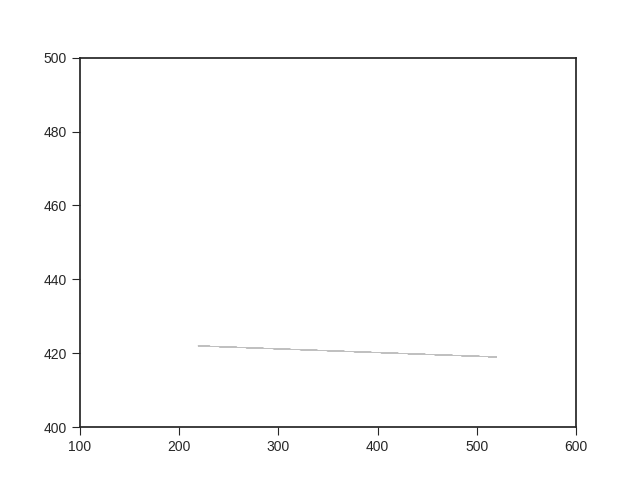

(400, 500)

In [9]:
position_lt = loading.position[np.logical_and(corrected_time > linear_track_epoch[0],
                                      corrected_time < linear_track_epoch[1]), :]
position_lt


# plt.savefig('lt_trajectory2911.png')



_, points, *_ = fklab.geometry.utilities.point2polyline(linear_track.vertices, position_lt, clip=('normal', 'normal'))

plt.plot(points[:, 0], points[:, 1], color='silver', lw=0.5)
plt.xlim(100, 600)
plt.ylim(400, 500)

<IPython.core.display.Javascript object>


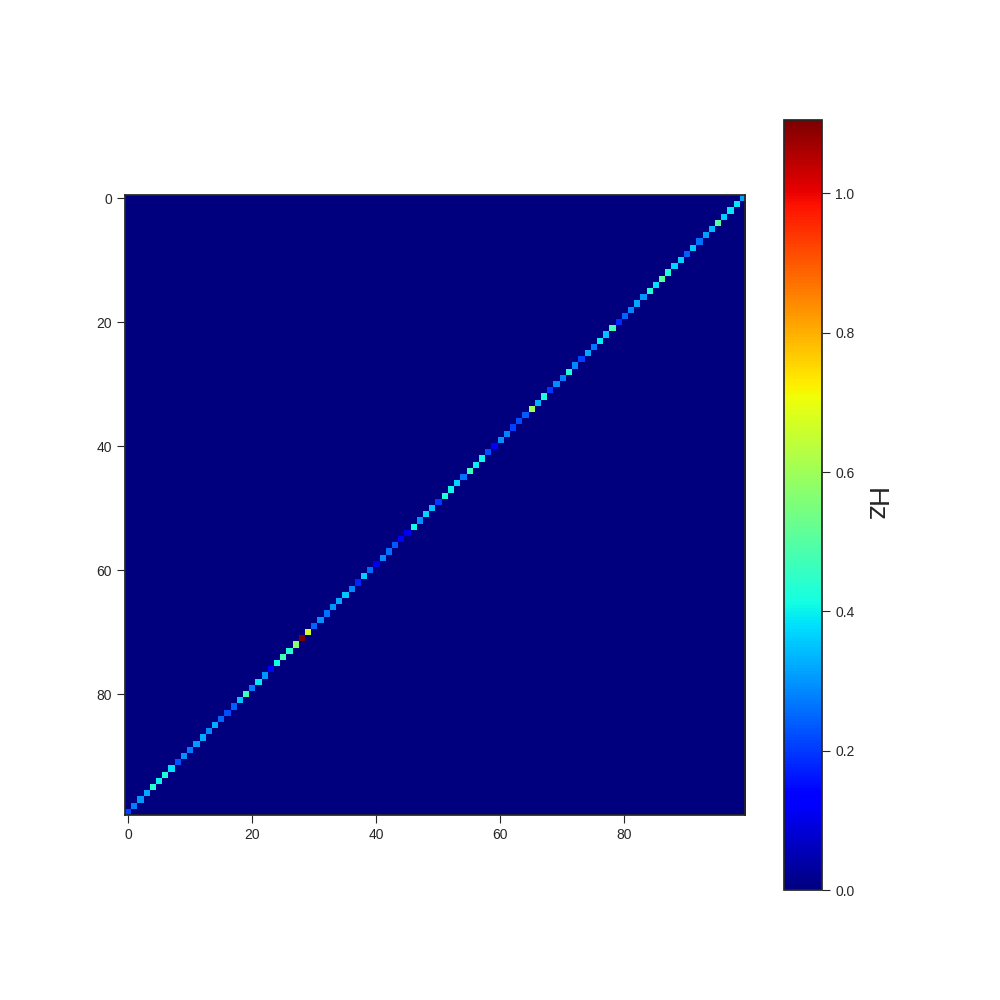

Text(0, 0.5, 'Hz')

In [10]:
#linear track
spike_t = []
spike_time_range = np.array(linear_track_epoch) - linear_track_epoch[0] + time_shift
# print(spike_time_range)
picked_channel = [325]
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(ls_data['id']):
#     print('cluster_id', cluster_id)
    if ls_data['channel'][cluster_index] not in picked_channel:
        continue
        
    spike_ts = loading.ks_spike_times[np.logical_and.reduce((
        loading.ks_spike_clusters == cluster_id,
        spike_time_range[0] <= loading.ks_spike_times[:, 0],
        loading.ks_spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t.extend(spike_ts)

    
# print(len(spike_t))


x = points[:, 0]
y = points[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

spike_times_binned = scipy.stats.binned_statistic(spike_t, 
                                                  np.ones_like(spike_t) / len(picked_channel), 
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

spike_bin = scipy.stats.binned_statistic_2d(y[mask], 
                                            x[mask], 
                                            spike_times_binned[mask], 
                                            statistic='mean', 
                                            bins=100)[0]
# print(spike_bin)
# plt.plot(x[mask], spike_bin)
spike_bin[np.isnan(spike_bin)] = 0.0
spike_bin[np.isinf(spike_bin)] = 0.0

# print(spike_bin.min(), spike_bin.max())

import fklab.signals.smooth as smooth

# #create kernel
K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
S = smooth.Smoother(K, unbiased=True)
spike_bin_smoothed = S(spike_bin)

plt.imshow(spike_bin, cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
# # plt.savefig('firingrate_2911_linear_track365.png')


In [11]:
ks_spike_times = loading.ks_spike_times[:, 0] + loading.evt_start_time / 1e6
print(ks_spike_times)
print(corrected_time)


[1.62439105e-02 1.70439105e-02 1.70439105e-02 ... 3.67358074e+03
 3.67358478e+03 3.67358711e+03]
[12103.76882074 12103.80838074 12103.84896074 ... 14473.63280074
 14473.67309774 14473.71245774]


<IPython.core.display.Javascript object>


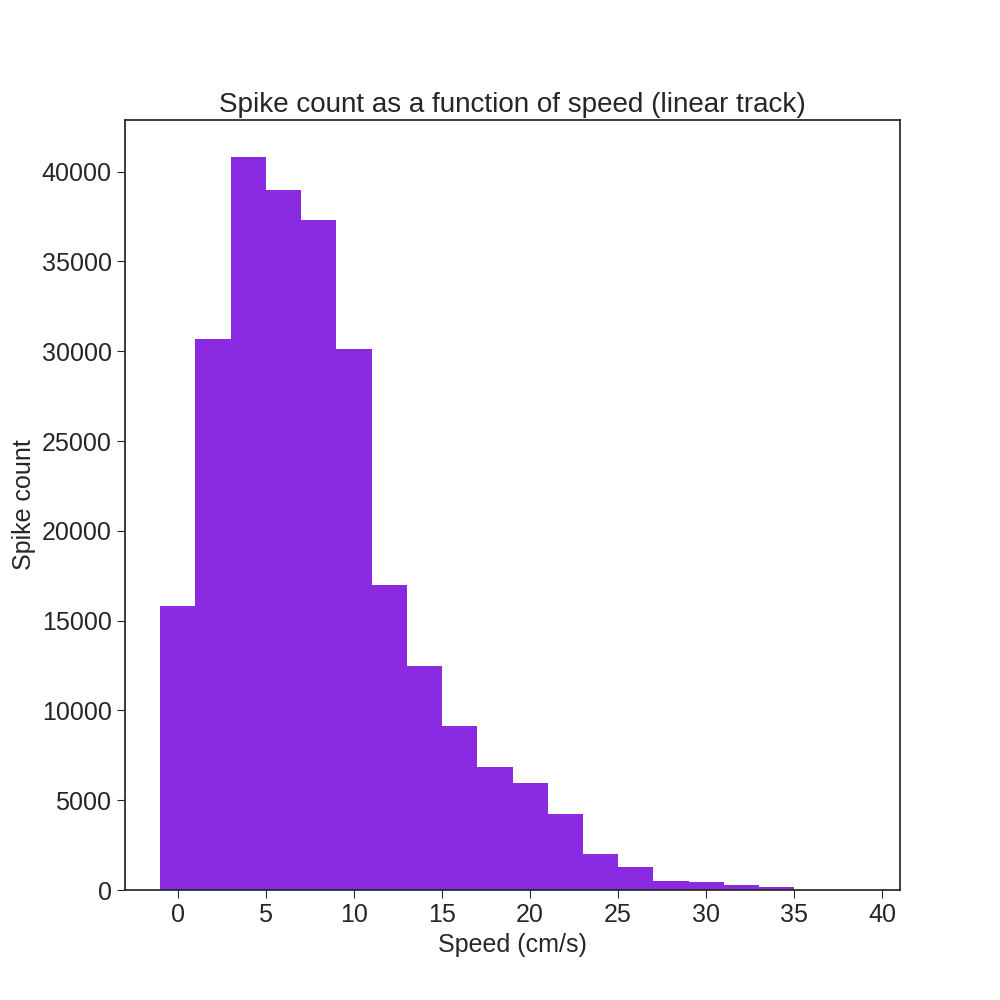

In [71]:
mask_lt = np.logical_and(corrected_time > linear_track_epoch[0],
                                      corrected_time < linear_track_epoch[1])
position_lt = loading.position[mask_lt, :]
position_lt

xlt = position_lt[:, 0]
ylt = position_lt[:, 1]
corrected_time_lt = corrected_time[mask_lt]

dlt = np.zeros((len(xlt), 2))
vel_lt = np.zeros_like(dlt)
time_vlt = np.zeros_like(xlt)
vel_vlt = np.zeros_like(xlt)
pixel = 0.27

for i in range(1, len(position_lt)-1):
    dlt[i, :] = (xlt[i+1] - xlt[i-1] , ylt[i+1] - ylt[i-1])
    time_vlt[i] = corrected_time_lt[i+1] - corrected_time_lt[i-1]
    vel_lt[i, :] = abs((dlt[i] / time_vlt[i]) * pixel)
    vel_vlt[i] = np.sqrt(vel_lt[i,0]**2 + vel_lt[i, 1]**2)


# plt.plot(corrected_time_ob, vel_v, color='r')

# run = vel_smoothed[vel_smoothed > 5 ]
# plt.plot(run)
vel_vlt[np.isnan(vel_vlt)] = 0.0

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel(bandwidth = 6)
S = smooth.Smoother(K, unbiased=True)
vel_smoothedlt = S(vel_vlt)
vel_smoothedlt


def time_spent(vel_rangelt, picked_cluster = None):
    
    idx = np.logical_and.reduce((
        vel_smoothedlt >= vel_rangelt[0],
        vel_smoothedlt <= vel_rangelt[1],
        ~np.isnan(xlt),
        ~np.isnan(ylt),
    ))

    dtlt = np.diff(corrected_time_lt, prepend=corrected_time_lt[0])
   
    if picked_cluster is None:
        cluster_x = slice(None, None)
    else:
        if len(picked_cluster) == 0:
            raise RuntimeError('empty picked_cluster')
            
        cluster_x = np.logical_or.reduce(tuple(
            loading.ks_spike_clusters == cluster
            for cluster in picked_cluster
        ))
    
    ks_spike_times = loading.ks_spike_times[cluster_x, 0] + loading.evt_start_time
    
    spike_x = scipy.stats.binned_statistic(ks_spike_times,
                                              values=np.ones_like(ks_spike_times),
                                              statistic='count',
                                              bins=corrected_time_lt)[0]
#     print(spike_x)
    spike_count = np.sum(spike_x[idx[:-1]])
    
    return np.sum(dtlt[idx]), spike_count

vel_bins = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
# dt_value = np.array([
#     time_spent(v_range)
#     for v_range in zip(vel_bins,vel_bins[1:])
# ])
# dt_value_357 = np.array([
#     time_spent(v_range, loading.get_cluster_ids([latsep['id']]))
#     for v_range in zip(vel_bins,vel_bins[1:])
# ])
# dt_value_323 = np.array([
#     time_spent(v_rangelt, loading.get_cluster_ids([323]))
#     for v_rangelt in zip(vel_bins,vel_bins[1:])
# ])
dt_value_lslt = np.array([
    time_spent(v_rangelt, ls_data['id'])
    for v_rangelt in zip(vel_bins,vel_bins[1:])
])

# sum(dt_value)
# print(dt_value)
plt.bar(np.array(vel_bins[:-1]), dt_value_lslt[:, 1], width=2, color='blueviolet')
# plt.bar(np.array(vel_bins[:-1]), dt_value_323[:, 1], width=2, color='fuchsia')
plt.xlabel("Speed (cm/s)")
plt.ylabel("Spike count")
plt.title("Spike count as a function of speed (linear track)")
plt.savefig("Spike count as a function of speed (linear track).png")

<IPython.core.display.Javascript object>


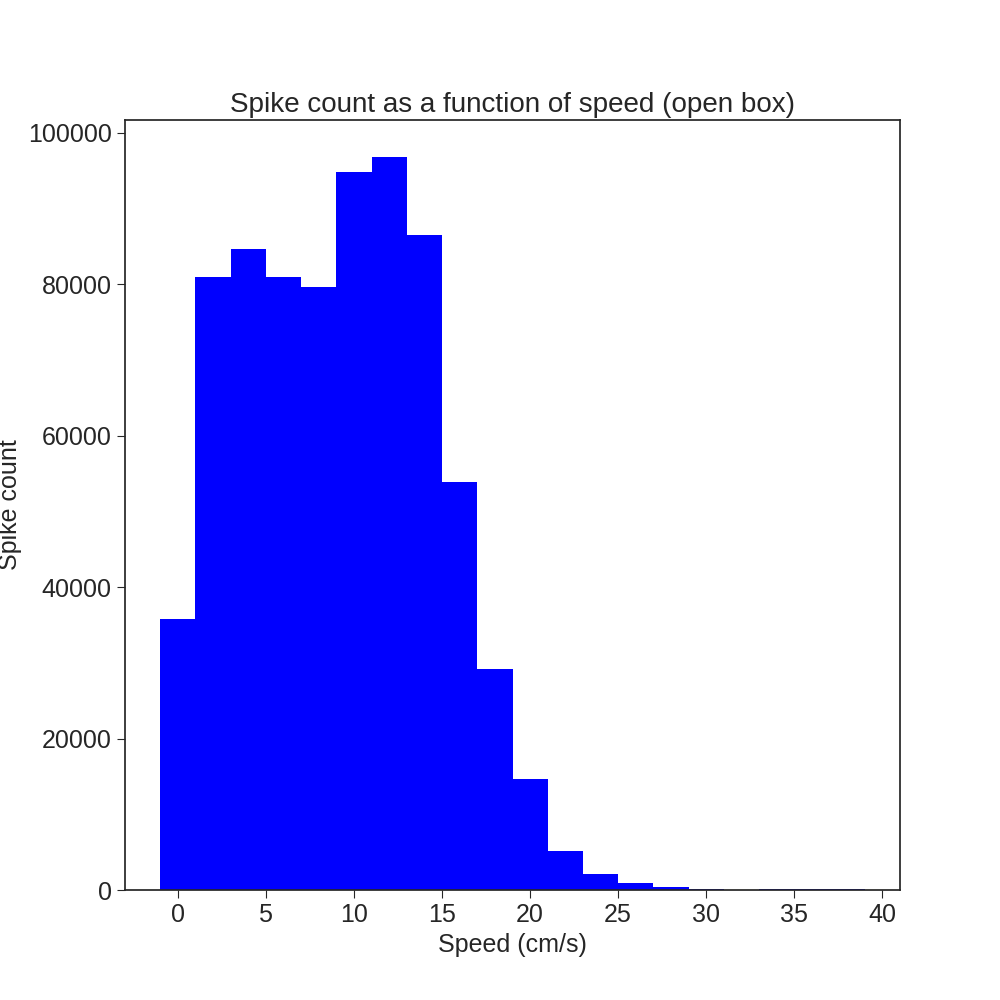

In [68]:
mask_ob = np.logical_and(corrected_time > open_box_epoch[0],
                                      corrected_time < open_box_epoch[1])
position_ob = loading.position[mask_ob, :]
position_ob

x = position_ob[:, 0]
y = position_ob[:, 1]
corrected_time_ob = corrected_time[mask_ob]

dx = np.diff(x)
dy = np.diff(y)
distance = np.sqrt(dx**2 + dy**2)
speed = distance / np.diff(corrected_time[mask_ob])   

d = np.zeros((len(x), 2))
vel = np.zeros_like(d)
time_v = np.zeros_like(x)
vel_v = np.zeros_like(x)
pixel = 0.27

for i in range(1, len(position_ob)-1):
    d[i, :] = (x[i+1] - x[i-1] , y[i+1] - y[i-1])
    time_v[i] = corrected_time_ob[i+1] - corrected_time_ob[i-1]
    vel[i, :] = abs((d[i] / time_v[i]) * pixel)
    vel_v[i] = np.sqrt(vel[i,0]**2 + vel[i, 1]**2)


# plt.plot(corrected_time_ob, vel_v, color='r')

# run = vel_smoothed[vel_smoothed > 5 ]
# plt.plot(run)
vel_v[np.isnan(vel_v)] = 0.0

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel(bandwidth = 6)
S = smooth.Smoother(K, unbiased=True)
vel_smoothed = S(vel_v)
vel_smoothed


def time_spent(vel_range, picked_cluster = None):
    
    idx = np.logical_and.reduce((
        vel_smoothed >= vel_range[0],
        vel_smoothed <= vel_range[1],
        ~np.isnan(x),
        ~np.isnan(y),
    ))

    dt = np.diff(corrected_time_ob, prepend=corrected_time_ob[0])
   
    if picked_cluster is None:
        cluster_x = slice(None, None)
    else:
        if len(picked_cluster) == 0:
            raise RuntimeError('empty picked_cluster')
            
        cluster_x = np.logical_or.reduce(tuple(
            loading.ks_spike_clusters == cluster
            for cluster in picked_cluster
        ))
    
    ks_spike_times = loading.ks_spike_times[cluster_x, 0] + loading.evt_start_time
    
    spike_x = scipy.stats.binned_statistic(ks_spike_times,
                                              values=np.ones_like(ks_spike_times),
                                              statistic='count',
                                              bins=corrected_time_ob)[0]
#     print(spike_x)
    spike_count = np.sum(spike_x[idx[:-1]])
    
    return np.sum(dt[idx]), spike_count

vel_bins = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
# dt_value = np.array([
#     time_spent(v_range)
#     for v_range in zip(vel_bins,vel_bins[1:])
# ])
# dt_value_357 = np.array([
#     time_spent(v_range, loading.get_cluster_ids([357, 365]))
#     for v_range in zip(vel_bins,vel_bins[1:])
# ])
# dt_value_323 = np.array([
#     time_spent(v_range, loading.get_cluster_ids([323]))
#     for v_range in zip(vel_bins,vel_bins[1:])
# ])
dt_value_ls = np.array([
    time_spent(v_range, ls_data['id'])
    for v_range in zip(vel_bins,vel_bins[1:])
])


# sum(dt_value)
# print(dt_value)
plt.bar(np.array(vel_bins[:-1]), dt_value_ls[:, 1], width=2, color='blue')
# plt.bar(np.array(vel_bins[:-1]), dt_value_323[:, 1], width=2, color='limegreen', alpha=0.5)
# plt.bar(np.array(vel_bins[:-1]), dt_value_357[:, 1], width=2, color='forestgreen')
plt.xlabel("Speed (cm/s)")
plt.ylabel("Spike count")
plt.title("Spike count as a function of speed (open box)")
plt.savefig("Spike count as a function of speed (open box).png")
plt.show()

In [61]:
dt_value_ls
spike_rate 

array([3.11152248, 3.35684416, 3.49358216, 3.58704292, 3.69194116,
       3.69883294, 3.73948183, 3.83313366, 3.75895368, 3.79428937,
       3.73232846, 3.81220405, 3.44625207, 3.60897693, 3.80582283,
       3.89804505, 4.11372327, 4.39838206])

/home/kasia/miniconda3/envs/fklab/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


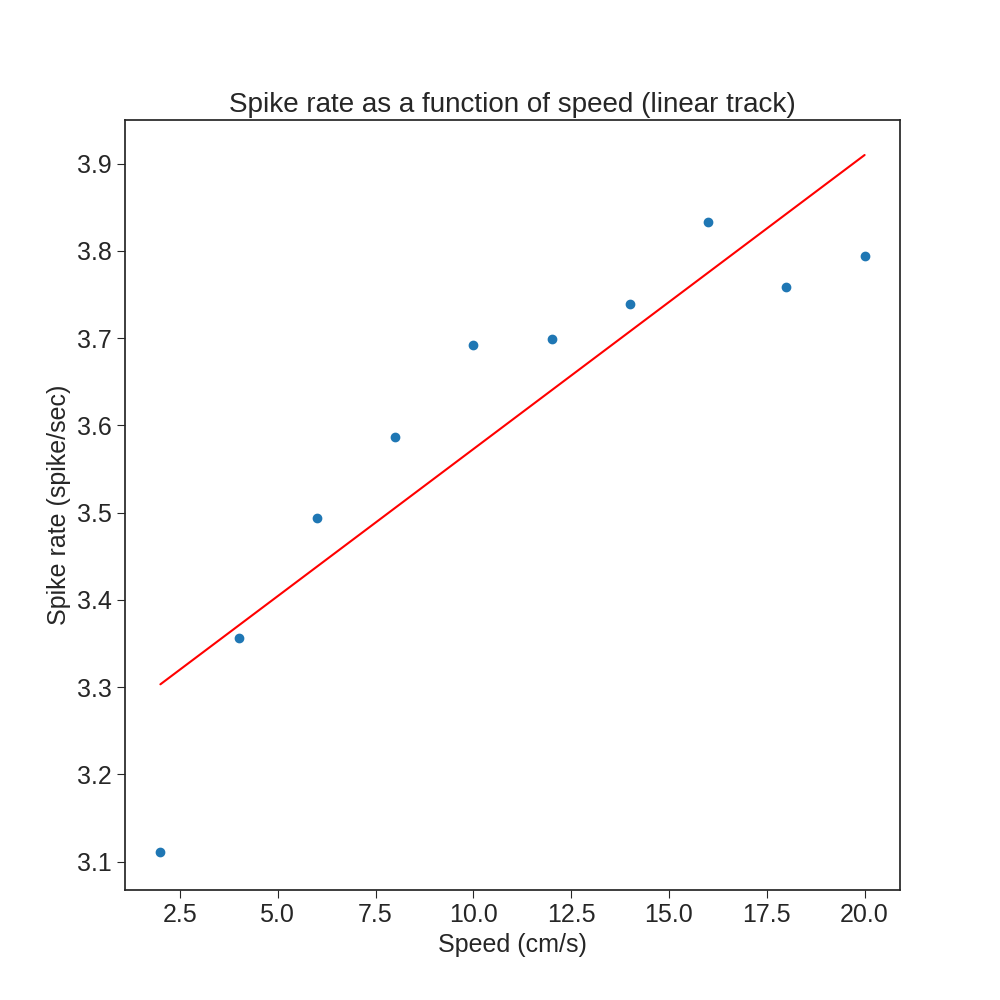

In [73]:
spike_rate = dt_value_lslt[:, 1] / (dt_value_lslt[:, 0]) / len(ls_data)
# spike_rate = dt_value_323[:, 1] / (dt_value_323[:, 0])
spike_rate = spike_rate[~np.isnan(spike_rate)]
vel_bins = [2,4,6,8,10,12,14,16,18,20]
x = vel_bins
# plt.plot(x, spike_rate, 'o' , color = 'deepskyblue')

from sklearn.linear_model import LinearRegression
x = np.array([vel_bins]).reshape((-1, 1))
y = spike_rate[:-8]
model = LinearRegression()
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
y_pred = model.predict(x)
# print('coefficient of determination:', r_sq)
# print('intercept:', model.intercept_)
# print('slope:', model.coef_)
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel("Speed (cm/s)")
plt.ylabel("Spike rate (spike/sec)")
plt.title("Spike rate as a function of speed (linear track)")
plt.savefig("Spike rate as a function of speed (linear track).png")
plt.show()

<IPython.core.display.Javascript object>


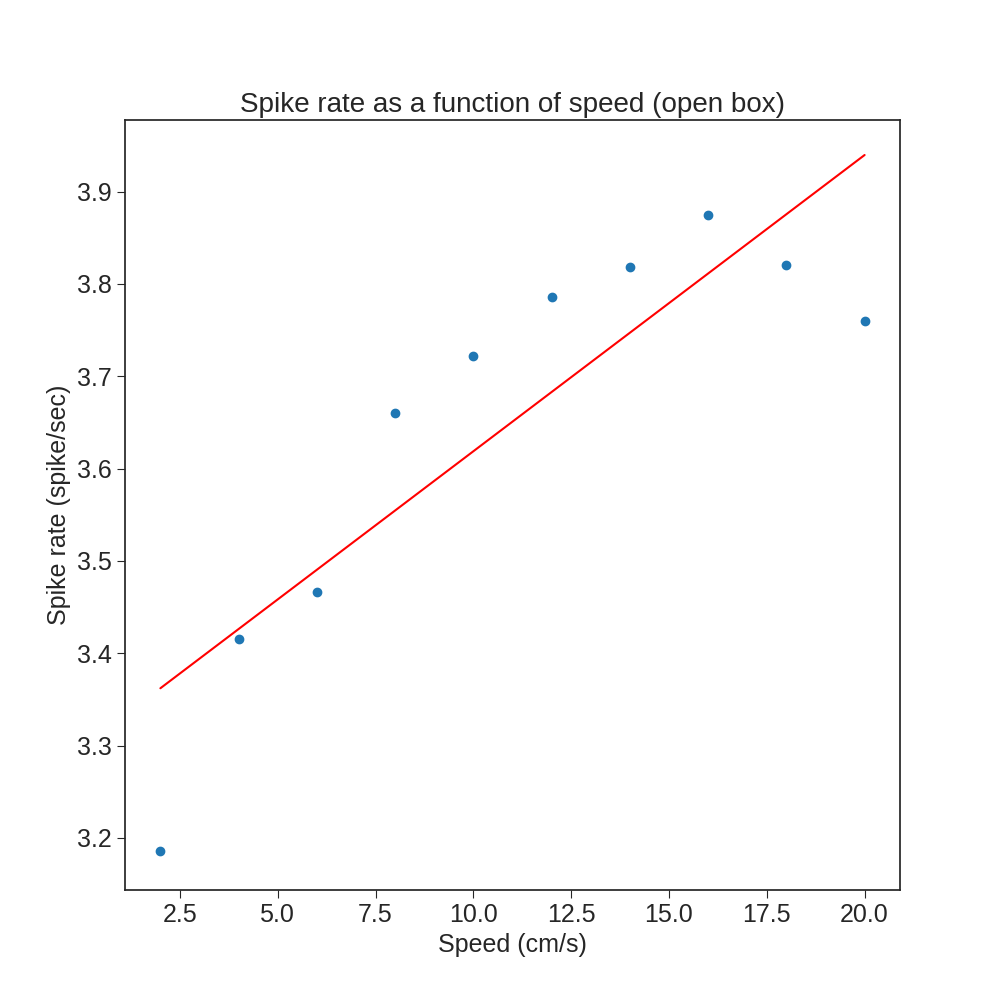

In [75]:
spike_rate = dt_value_ls[:, 1] / (dt_value_ls[:, 0]) / len(ls_data)
spike_rate = spike_rate[~np.isnan(spike_rate)]
# spike_rate = spike_rate[spike_rate[:-5]]
vel_bins = [2,4,6,8,10,12,14,16,18,20]
x = vel_bins
# plt.plot(x, spike_rate, 'o' , color = 'deepskyblue')

from sklearn.linear_model import LinearRegression
x = np.array([vel_bins]).reshape((-1, 1))
y = spike_rate[:-10]
model = LinearRegression()
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
y_pred = model.predict(x)
# print('coefficient of determination:', r_sq)
# print('intercept:', model.intercept_)
# print('slope:', model.coef_)
plt.scatter(x, y)
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.plot(x, y_pred, color='red')
plt.xlabel("Speed (cm/s)")
plt.ylabel("Spike rate (spike/sec)")
plt.title("Spike rate as a function of speed (open box)")
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.savefig("Spike rate as a function of speed (open box).png")
plt.show()

In [45]:
y = spike_rate[:-5]
len(y)

15

In [64]:
dt_value_ls

array([[7.50130280e+01, 3.58410000e+04],
       [1.58019740e+02, 8.09540000e+04],
       [1.62772446e+02, 8.46250000e+04],
       [1.47407748e+02, 8.09420000e+04],
       [1.42650582e+02, 7.96320000e+04],
       [1.66999436e+02, 9.48350000e+04],
       [1.69114339e+02, 9.68570000e+04],
       [1.48964694e+02, 8.65750000e+04],
       [9.39644050e+01, 5.38500000e+04],
       [5.17966070e+01, 2.92140000e+04],
       [2.58306350e+01, 1.47000000e+04],
       [9.00127000e+00, 5.09500000e+03],
       [3.96471500e+00, 2.17000000e+03],
       [1.67875900e+00, 8.83000000e+02],
       [6.37312000e-01, 3.71000000e+02],
       [2.00246000e-01, 8.00000000e+01],
       [7.99590000e-02, 6.40000000e+01],
       [8.13700000e-02, 7.00000000e+01],
       [8.11690000e-02, 7.30000000e+01],
       [1.59255000e-01, 1.58000000e+02]])